# Conductance-Based Spiking Neural Network (conductance-SNN)

## Install required packages

Install required packages

In [2]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import os
import matplotlib.animation as animation
import copy
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d

## Functions used for simulation

### Initialize weights

Initialize weights

In [1]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    
    Returns
    ----------
    D : array
        weights per dimension, size (N, d)
    
    """
        
    if d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)       
        D = np.zeros((N,d))
        D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        
    else:
        D = np.random.normal(0, 0.5, size=(N, d)) 
               
    return D

### Initialize parameters

Initialize parameters

In [22]:
def initialize_params(N, d, dt, iterations, D):
    """ Initialize variables and parameters. 
    
    Parameters
    ----------
    N : int
        number of neurons
    d : int
        number of dimensions
    dt : int
        time step
    iterations : int
        length of the simulation
    weight : string, optional
        all neurons have same weights ("homogeneous") or neurons have different weights ("heterogeneous")
    gamma : int, optional
        read-out weight of the neurons (only applies when weights="homogeneous")
        
    Returns
    ----------
    t : 1D-array
        timesteps
    x_est : array
        input estimate per timestep, size (d, iterations)
    o : array
        spike trains, with value 0 if there is no spike and value 1/dt if there is a spike,
        size (N, iterations) 
    voltage : array
        voltages, size (N, iterations) 
    D : 1D-array
        read-out weights of the neurons
    T : 1D-array
        threshold of the neurons
    
    """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.zeros((d, iterations))

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [np.dot(weight, weight) for weight in D]

    return (t, voltage, x_est, o, T)

### Time varying signal

Create time varying signal

In [5]:
def time_varying_signal(d):
    """ Initialize time varying, sinusoidal input signal. 

    Parameters:
    d: int
        number of dimensions
    
    Returns
    ----------
    x : array
        input per timestep, size (d, iterations)
    c : array
        sum of the input and input derivative per timestep, size (d, iterations)
        
    """
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)

    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))

    return(c, x)

In [4]:
def time_varying_signal_plateau(c_upp=1):
    """ Initialize time varying input signal with a plateau. 
    
    Parameters
    ----------
    c_upp : int, optional
        value of the plateau
    
    Returns
    ----------
    x : 1D-array
        input per timestep
    c : 1D-array
        sum of the input and input derivative per timestep
        
    """
        
    c = []
    
    # create time-varying signal
    x_t = np.ones((d, iterations)) * c_upp

    step = 150
    x_t[:, 0:step] = 0
    x_t[:, iterations - 2 * step:iterations] = 0

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal
        
    for i in range(d):
        dxdt = np.diff(x[i,:])/dt
        c.extend(x[i, :-1] + dxdt)
        
    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))
    
    return (c, x)

### Run simulation

In [12]:
def run(rho, E_e=1, E_i=-1, lambda_constant=False, var=0):
    """ Run simulation of spike coding network. At each time step, the voltage and input estimate is computed
    using the Euler's method. The network follows a spike rule that if one of the voltage reaches threshold the
    network outputs a spike wherafter the voltages and input estimate are updated. 
    
    Parameters
    ----------
    rho : int
        network parameter
    E_e : int, optional
        excitatory reversal potential
    E_i : int, optional
        inhibitory reversal potential
    lambda_constant : boolean, optional
        defines lambda as a constant (True) or as its true value (False)
    var : int, optional
        value of lambda (only applies when lambda_constant=True)
    
    
    """
    
    lambda_val = np.zeros(N)
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = (-1/tau) * x_est[:, t - 1] + np.dot(D.T, o[:, t - 1])
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt 
        
        # compute lambda
        lambda_val = np.zeros(N)
        if lambda_constant == False:
            for i in range(N):
                lambda_val = 1/np.dot(D, x[:, t] + x_est[:, t] + rho)
        elif lambda_constant == True:
            lambda_val = 1/var
                
        # update voltages
        dVdt = lambda_val * (-rho * voltage[:, t - 1] + np.dot(D, c[:, t - 1]) * (E_e - voltage[:, t - 1]) + \
                            np.dot(D * D.T, o[:, t - 1]) * (E_i - voltage[:, t - 1]))
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt
        
        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [7]:
def zero_to_nan(spike_trains):
    """Replace every 0 with 'nan' and return a copy.
    
    Parameters
    ----------
    spike_trains : array
        spike trains of the different neurons
    
    Returns
    ----------
    o_Nan : array
        array where every 0 is replaced by NaN, size (spike_trains.shape)
        
    """
    
    o_Nan = [float('nan') if x==0 else x for x in spike_trains]
    
    return o_Nan

In [13]:
def visualize(color, plot_voltage=True, plot_c=False):
    """ Visualize results of the simulation of the spike coding network. Return one plot with the input and input estimate,
    one plot with the spike trains, and N plots for the voltages.
    
    Parameters
    ----------
    color : array
        RGB values for the different neurons, size (N, 3)
    plot_voltages : boolean, optional
        voltages are plotted (True) or not (False)
    plot_c : boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    
    """ 
    
    # initialize plots
    if plot_voltage == True:
        plot = d + N + 1
    else:
        plot = d + 1
    
    pl.subplots(plot, 1, figsize=(8, 10))
    pl.subplots_adjust(hspace=0.2 * N)
    counter = 1
    pl.rc('text', usetex=True)
    
    # plot input and input estimate
    for i in range(1, d + 1):
        pl.subplot(plot, 1, counter)
        pl.plot(t, x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
        pl.plot(t, x[i - 1,:], label='$x_{%i}$' %i, color='k')
        if plot_c == True:
            pl.plot(t[:-1], c[0, :], '--k', label=r'$x + \dot{x}$', alpha=0.2)
        pl.xlim(0, iterations * dt)
        pl.legend()
        counter = counter + 1
    
    # plot spike trains
    fig = pl.subplot(plot, 1, counter) 
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(t, values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
    pl.title('Spike train', fontsize=15)
    pl.xlim(0, iterations * dt)
    pl.legend()
    counter = counter + 1
    
    # plot voltages
    if plot_voltage == 1: 
        # plot voltage per neuron over time
        for i in range(1, N + 1):
            pl.subplot(plot, 1, counter)
            
            pl.plot(t, voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
            pl.plot(t, np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E')
            pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I')
            
            pl.xlim(0, iterations * dt)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i,  fontsize=15)
            pl.legend()
            counter = counter + 1
        
    pl.xlabel('time')

## Other functions

### Membrane voltage 

In [29]:
def visualize_voltage(rho):
    """ Compute and visualize membrane voltage of each neuron. 
    
    Parameters
    ----------
    rho: int
        network parameter        
    
    Returns
    ----------
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    # compute voltage (by method 2)
    voltage_offline = np.zeros((N, iterations))
    for i in range(N):
        voltage_offline[i, :] = np.dot(D[i].T, x - x_est) / np.dot(D[i].T, x + x_est + rho)

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))

    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = D_{i}^{T}(\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{i}^{T} D_{k} s_{k}) (-1 - V_{i})$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.plot(t, np.ones(iterations) * T[i - 1], color='gray', label='threshold') 
        pl.ylabel('voltage')
        pl.xlabel('time')
        
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x} + \rho)}$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage_offline[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.plot(t, np.ones(iterations) * T[i - 1], color='gray', label='threshold') 
        pl.xlabel('time')
        pl.legend()
        
    return voltage_offline

In [30]:
def plot_voltage_diff(voltage_online, voltage_offline):
    """ Plot difference between online and offline voltage.
    
    Parameters
    ----------
    voltage_online : array
        voltages computed using the online method, size (N, iterations)
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, voltage_online - voltage_offline, 'k')
    pl.ylim(-1, 1)
    pl.ylabel(r'$V_{online} - V_{offline}$')
    pl.xlabel('time')

## Run simulation

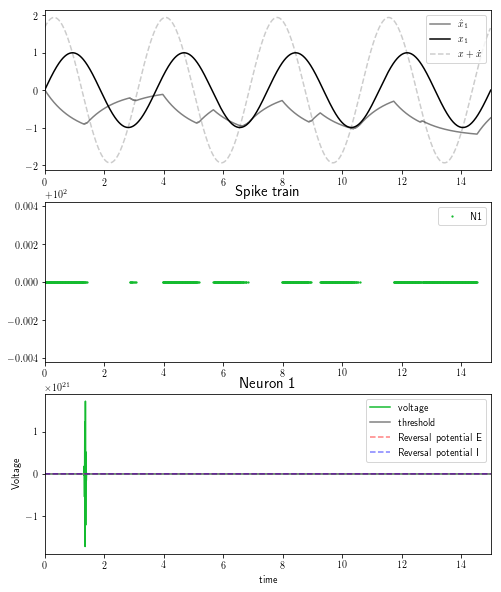

In [27]:
N = 1                                                    # number of neurons
d = 1                                                    # number of dimensions
dt = 0.01                                                # time step
iterations = 1500                                        # length of simulation
tau = 1                                                  # time constant
c_upp = 1                                                # input value
gamma = 1                                                # read-out weight
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
rho = 0.1
lambda_constant = False                                  # indicates use of lambda                   
var = 1

# run simulation
D = initialize_weights(N, d)                                                # initialize decoding weights
t, voltage, x_est, o, T = initialize_params(N, d, dt, iterations, D)        # initialize parameters
c, x = time_varying_signal(d)                                               # create d-dimensional input signal
#c, x = time_varying_signal_plateau(c_upp=c_upp) 
run(rho, E_e, E_i, lambda_constant=lambda_constant, var=var)                # run spiking network
visualize(color, plot_voltage=True, plot_c=True)                            # plot results

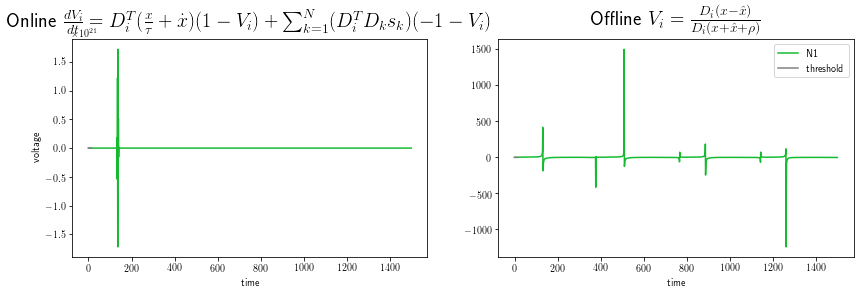

In [31]:
voltage_offline = visualize_voltage(rho)

In [35]:
neuron = 2
if neuron < 1 or neuron > N:
    print("Enter valid neuron")
else:
    plot_voltage_diff(voltage[neuron - 1, :], voltage_offline[neuron - 1, :])

Enter valid neuron
